In [1]:
import pandas as pd
sales = pd.read_excel('Datos_examen_final_17Co2024_Grupo4.xlsx')
sales["Mes"] = sales["Fecha"].dt.month # alternativa: dt.month_name()
# sales["DiaDeSemana"] = sales["Fecha"].dt.weekday
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   365 non-null    datetime64[ns]
 1   Ventas  365 non-null    float64       
 2   Mes     365 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 7.3 KB


## Ventas por mes en supermercado 'Santa Ana'

In [2]:
import matplotlib.pyplot as plt
import math
def plot_sales(data, plot_fun,title, n = 3, pad = 2.0, fig_size = (10,10)):
    m = math.ceil(len(data)/n)
    figure, axis = plt.subplots(m,n, figsize=fig_size)
    figure.tight_layout(pad = pad)
    for i in range(m*n):
        row = i//n
        col = i%n
        if i < len(data):
            axis[row][col].set_title(f"{title}: {i+1}")
            plot_fun(data[i], axis[row][col])
        else: 
            axis[row][col].axis('off')
            
sales_per_month = [sales[sales["Mes"] == (i+1)]["Ventas"].values for i in range(12)]

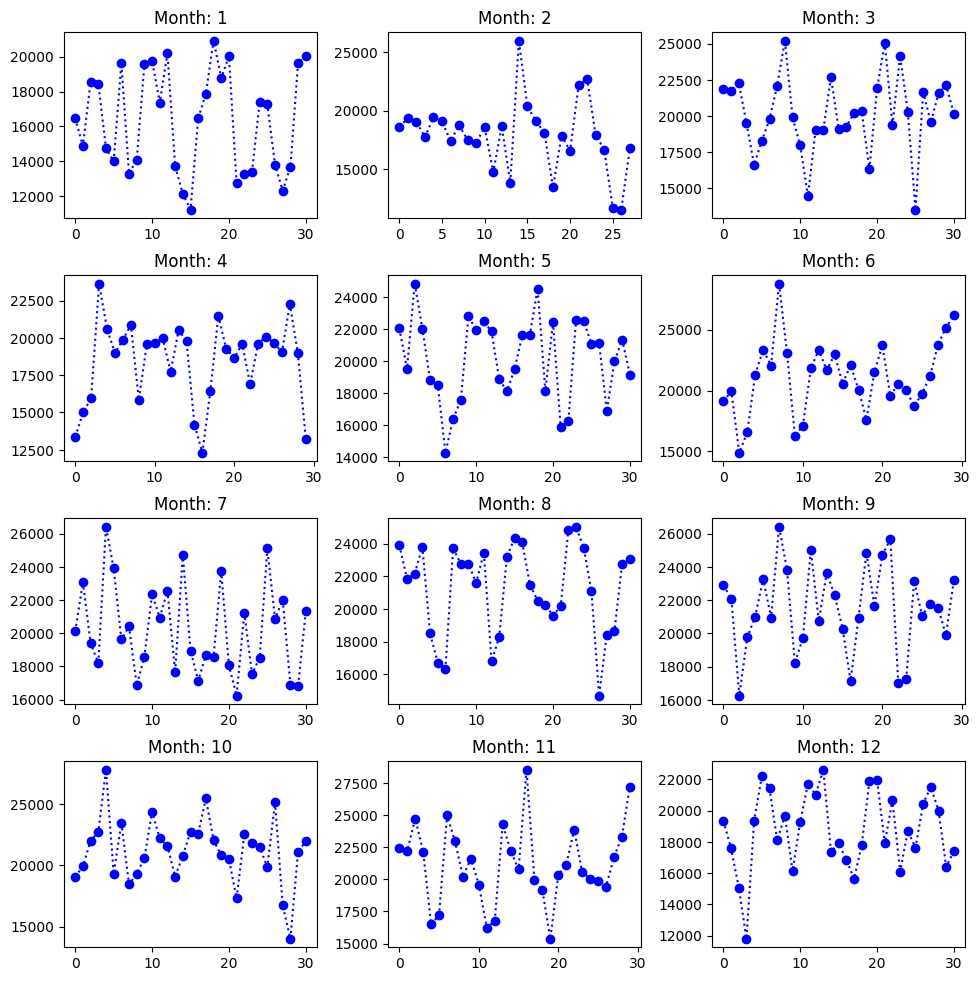

In [3]:
def month_sale_plot_fun(data, ax):    
    ax.plot(range(len(data)), data, color='blue', linestyle=':', marker='o')
plot_sales(sales_per_month,  month_sale_plot_fun , title='Month')

## 1 . Determinen intervalos de confianza empíricos para el supermercado 'Santa Ana' en cada mes, para siginificancias del 95% y el 99%.

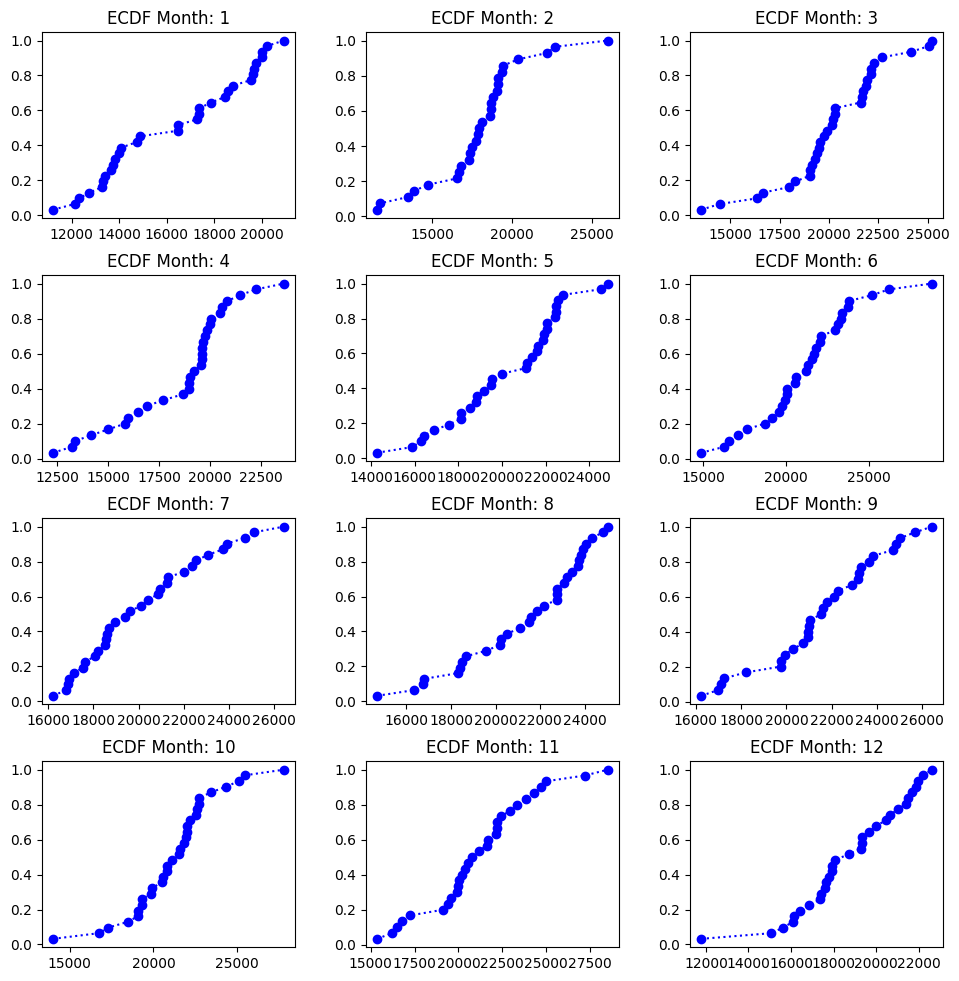

In [4]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf_per_month= list(map(lambda x: ECDF(x), sales_per_month))
def month_ecdf_plot_fun(data, ax):    
    # print('data:', data)
    ax.plot(data.x, data.y, color='blue', linestyle=':', marker='o')
plot_sales(ecdf_per_month,  month_ecdf_plot_fun , title='ECDF Month')


In [5]:
# import numpy as np
# import pandas as pd
# df = pd.DataFrame()
# alphas = [0.95, 0.99]
# for alpha in alphas:
#     for ecdf in ecdf_per_month:
#         # asumimos que es prueba de cola izquierda
#         index = -1
#         for i in range(len(ecdf.y)):
#             if ecdf.y[i] > alpha: 
#                 index = i
#                 break
#         # print(ecdf.y[-5:])
#         row = {
#             'Significancia': alpha,
#             'Significancia_eff': ecdf.y[index],
#             'Intervalo X=(': ecdf.x[0],
#             ')': ecdf.x[index]
#         }
#         df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)         
# display(df)

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import norm
df = pd.DataFrame()
confidences = [0.95, 0.99]
month_names = ["January","February","March","April","May","June","July","August","September","October","November","December"]

for month_name, sales in zip(month_names, sales_per_month):
    for confidence in confidences:
        
        μ = np.mean(sales)
        σ = np.std(sales)
        new_σ = σ/np.sqrt(len(sales))
        # ppf = Φ^-1
        z = norm.ppf(confidence, loc=μ, scale=new_σ)
        row = {
            'Month': month_name,
            'confidence:': confidence,
            'alpha': 1-confidence,
            'Intervalo X=(': '-inf',
            ')': z
        }
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)         
display(df)

,Month,confidence:,alpha,Intervalo X=(,)
0,January,0.95,0.05,-inf,17173.289055
1,January,0.99,0.01,-inf,17530.426679
2,February,0.95,0.05,-inf,18835.015598
3,February,0.99,0.01,-inf,19221.644241
4,March,0.95,0.05,-inf,20946.757185
5,March,0.99,0.01,-inf,21268.642944
6,April,0.95,0.05,-inf,19253.200904
7,April,0.99,0.01,-inf,19592.872921
8,May,0.95,0.05,-inf,20927.055478
9,May,0.99,0.01,-inf,21242.970241


## 2. Realicen pruebas ANOVA para determinar si las ventas esperadas de todas las tiendas son iguales o no, con una significancia del 95%.

Asumimos que las varianzas de todos los grupos son iguales.
 
Asumimos que los grupos estan distribuido de forma normal.

Las variaciones de un grupo son independientes.

Este desarollo se basa en la ley de varianza total.
$$
Var(Y) = \sigma^2 + Var(\mu_j)
$$

Si H0 es verdadera, todas las medias son la misma
=> 
$$
Var(Y) = \sigma^2 + 0
$$

Estadistico
$$
F =\frac{Var(\mu_j)}{\sigma^2} = \frac{\frac{\sum (\bar{\mu} - \mu_j)^2}{j-1}}{\frac{\sum(Y_i - Y_{ij})^2}{N-j}}
$$


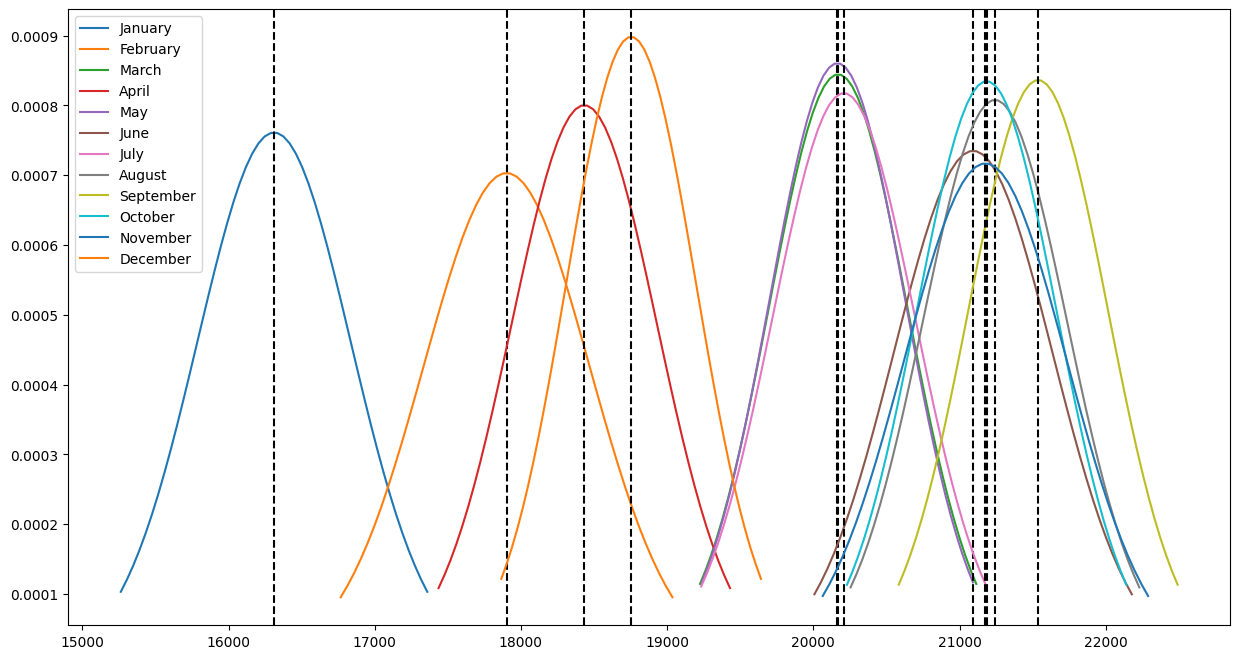

In [7]:
import numpy as np
from scipy.stats import norm

month_names = ["January","February","March","April","May","June","July","August","September","October","November","December"]

fig, ax = plt.subplots(figsize=(15,8))   
for month_name, sales in zip(month_names, sales_per_month):
    μ = np.mean(sales)
    n = len(sales)
    σ = np.std(sales)/np.sqrt(n)
    x_axis = np.linspace(μ-2*σ,μ+2*σ)
    plt.plot(x_axis,norm.pdf(x_axis, μ, σ), label=month_name)
    plt.axvline(x=μ, ls='--', color='black')
plt.legend()
plt.show()

In [12]:
from scipy.stats import f_oneway
f_stat, p_value = f_oneway(*sales_per_month)

alpha = 0.05
print('f_stat:', f'{f_stat:.2f}')
print('p_value:', f'{p_value:.20f}')

if p_value < alpha:
    print("Rechazamos H0. Hay evidencia para afirmar que al menos una media es diferente")
else: 
    print("No se rehaza H0. Hay evidencia suficiente para afirmar que las medias son diferentes")

f_stat: 10.41
p_value: 0.00000000000000014811
Rechazamos H0. Hay evidencia para afirmar que al menos una media es diferente


## 4. Determinen la distribución a posteriori del parámetro p de porcentaje de morosidad. Determinar su media y su varianza